In [28]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

from datasets import load_dataset
from Alz_preprocessing import get_train_test_datasets

In [29]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
def compute_weights(hf_split):

    #Compute class weights for a Hugging Face dataset split.

    #Args: hf_split: A Hugging Face dataset split (e.g., dataset['train'])

    #Returns: class_weights (dict): A dictionary mapping class index to its weight.

    labels = np.array(hf_split['label'])
    classes = np.unique(labels)

    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    return dict(zip(classes, weights))

In [30]:
dataset = load_dataset("Falah/Alzheimer_MRI")
label_names = dataset['train'].features['label'].names
train_ds, test_ds = get_train_test_datasets(dataset, label_names)

# Compute class weights to handle class imbalance
class_weights = {int(k): float(v) for k, v in compute_weights(dataset['train']).items()}
print("Class Weights:", class_weights)

Class Weights: {0: 1.7679558011049723, 1: 26.122448979591837, 2: 0.49883086515978176, 3: 0.7186973610331274}


In [31]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomHeight(0.1),
    tf.keras.layers.RandomWidth(0.1)
])


In [32]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze all layers of ResNet50 for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply augmentation
x = base_model(x, training=False)  # Ensure frozen base during Phase 1
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # Dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(label_names), activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/10
    160/Unknown 131s 794ms/step - accuracy: 0.2499 - loss: 1.7740

/home/cdennis51/.pyenv/versions/3.10.6/envs/Neurocheck/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


160/160 ━━━━━━━━━━━━━━━━━━━━ 159s 973ms/step - accuracy: 0.2499 - loss: 1.7735 - val_accuracy: 0.3672 - val_loss: 1.3459
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.2626 - loss: 1.6888

2025-07-29 20:23:04.612518: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 153s 959ms/step - accuracy: 0.2625 - loss: 1.6883 - val_accuracy: 0.3586 - val_loss: 1.2649
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 153s 956ms/step - accuracy: 0.2582 - loss: 1.6501 - val_accuracy: 0.4195 - val_loss: 1.2423
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 153s 955ms/step - accuracy: 0.2808 - loss: 1.5415 - val_accuracy: 0.5008 - val_loss: 1.2487
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 151s 947ms/step - accuracy: 0.2571 - loss: 1.5083 - val_accuracy: 0.4953 - val_loss: 1.2655
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 152s 951ms/step - accuracy: 0.2515 - loss: 1.5087 - val_accuracy: 0.4930 - val_loss: 1.3443


In [34]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 677ms/step - accuracy: 0.4035 - loss: 1.2440
Test Accuracy: 0.42


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

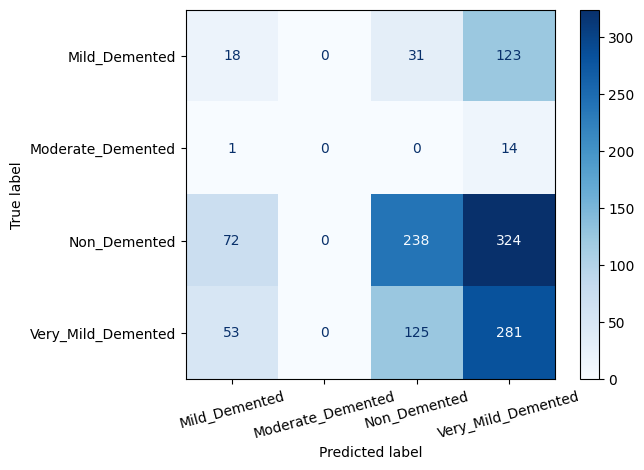

In [35]:
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', xticks_rotation=15)
plt.show()


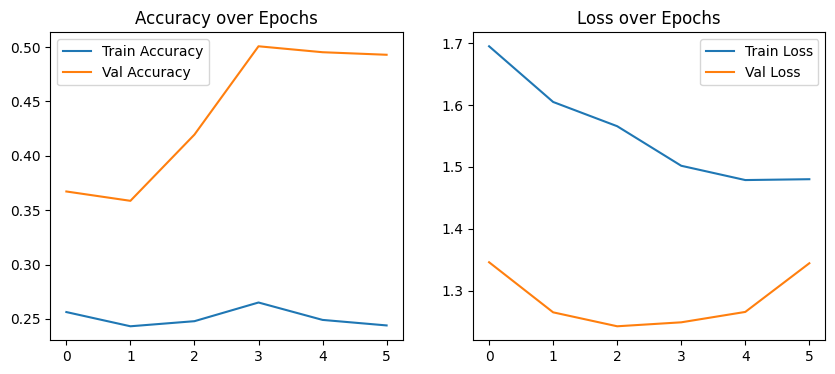

In [36]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()